**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andr√©s (gonzalo.marcosa@um.es)
- Francisco Jos√© L√≥pez Fern√°ndez (franciscojose.lopezf@um.es)

**M√°ster de Inteligencia Artificial**

| **Facultad de Inform√°tica** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


# **Pr√°ctica 2.  Aprendizaje en entornos complejos**

## **1. Preparaci√≥n del Entorno**

### 1.1 Introducci√≥n.  

Este notebook se enfoca en la implementaci√≥n y an√°lisis de un agente que utiliza **Aprendizaje por Refuerzo** para resolver distintos entornos que nos ofrece `gymnasium`.  

Los entornos que vamos a utlizar son: 

 - **FrozenLake (4x4)**

### 1.2. Instalaci√≥n de Dependencias

Se instalan las librer√≠as necesarias para trabajar con el entorno de simulaci√≥n `gymnasium`, lo que permite crear un ambiente controlado donde el agente pueda interactuar y aprender. Este entorno simula una cuadr√≠cula donde el agente debe navegar para alcanzar una meta, mientras se enfrenta a varios desaf√≠os.

In [6]:
%%capture
# ! pip install 'gym[box2d]==0.20.0'
# ! pip install gymnasium[box2d]
# ! pip install "gymnasium[toy-text]
# ! pip install gymnasium 
# ! pip install numpy
# ! pip install matplotlib
# ! pip install tqdm
# ! pip install torch

### 1.3 Librer√≠as

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import random
import gc
import torch
from src_agents import *
from src_plotting import *

from src_agents.deepQLearning import *
import random
import numpy as np
import torch
import gymnasium as gym
from src_agents.sarsaSemiGradiente import FrozenLakeWrapper, train_sarsa#, GraphVisualizer
from src_plotting import *

### 1.4 Importaci√≥n de los Entornos 

Se cargan dos entornos diferentes para el agente:
- **FrozenLake (4x4)** es un peque√±o lago congelado en el que el agente debe navegar para llegar a su destino, evitando caer en el agua. Este entorno es especialmente √∫til para un aprendizaje inicial, ya que no es resbaladizo, lo que facilita la comprensi√≥n de c√≥mo el agente interact√∫a con el entorno.



### 1.5 Funciones para Mostrar los Resultados
Se definen varias funciones para graficar y visualizar los resultados del entrenamiento del agente. Estas funciones permiten analizar el desempe√±o del agente en diferentes aspectos.
1.`plot(list_stats)`  
   - **Descripci√≥n**: Graficar√° la proporci√≥n de recompensas obtenidas en cada episodio del entrenamiento. Este gr√°fico proporciona una visualizaci√≥n clara del progreso del agente, mostrando c√≥mo mejora su desempe√±o a medida que avanza en el proceso de aprendizaje.

2. `plot_episode_lengths(episode_lengths, window=50)`  
   - **Descripci√≥n**: Graficar√° la longitud de los episodios en el entrenamiento, y calcular√° y mostrar√° la tendencia de las longitudes utilizando una media m√≥vil.

3. `plot_policy_blank(Q, env)`  
   - **Descripci√≥n**: Dibuja la pol√≠tica aprendida por el agente sobre un entorno vac√≠o, representando las acciones √≥ptimas en cada estado de la **Q-table** del agente con flechas (izquierda, abajo, derecha, arriba).

4. `plot_comparison(stats_list, labels, title="Comparaci√≥n de Resultados de Entrenamiento")`  
   - **Descripci√≥n**: Compara la evoluci√≥n de las recompensas obtenidas por diferentes algoritmos o agentes a lo largo del entrenamiento, permitiendo visualizar el rendimiento relativo de cada uno.

5. `plot_episode_lengths_comparison(episode_lengths_list, labels, window=50, title="Comparaci√≥n de Longitudes de Episodios")`  
   - **Descripci√≥n**: Compara las longitudes de los episodios de diferentes agentes, mostrando las longitudes y las tendencias de cada uno en subgr√°ficas separadas, con sombreado y media m√≥vil.

Todas las funciones y clases relacionadas con la visualizaci√≥n de gr√°ficos se encuentran en el archivo `src_agents/plotting.py`. Para utilizarlas, ser√° necesario importar las librer√≠as correspondientes desde esa ruta.

## **2. Dise√±o del Agente**

### 2.1 Estructura del Agente

Este es la estructura que contiene la implementaci√≥n de distintos agentes, organizados en m√≥dulos espec√≠ficos para facilitar su uso y mantenimiento.  

Cada agente hereda de una clase base (`agent.py`) y utiliza diferentes estrategias de aprendizaje, como **Monte Carlo**, **Q-Learning** y **SARSA**. Adem√°s, se incluyen m√≥dulos auxiliares para definir pol√≠ticas de exploraci√≥n y visualizar resultados.

```plaintext
|-- üìÇ src_agents                                    # Carpeta principal que contiene los agentes de Aprendizaje por Refuerzo
|   |-- üìÑ __init__.py                               # Archivo que convierte el directorio en un paquete de Python
|   |-- üìÑ agent.py                                  # Clase base para todos los agentes
|   |-- üìÑ deepQLearning.py                          # Implementaci√≥n del agente Deep Q-Learning (DQN)
|   |-- üìÑ monteCarloOnPolicy.py                     # Implementaci√≥n del agente Monte Carlo On-Policy
|   |-- üìÑ monteCarloOffPolicy.py                    # Implementaci√≥n del agente Monte Carlo Off-Policy
|   |-- üìÑ qLearning.py                              # Implementaci√≥n del agente Q-Learning
|   |-- üìÑ sarsa.py                                  # Implementaci√≥n del agente SARSA tabular
|   |-- üìÑ sarsaSemiGradiente.py                     # Implementaci√≥n del agente SARSA Semigradiente
|   |-- üìÑ politicas.py                              # Definici√≥n de pol√≠ticas de exploraci√≥n como epsilon-greedy y softmax

|-- üìÇ src_plotting                                  # Carpeta con herramientas de visualizaci√≥n de resultados
|   |-- üìÑ __init__.py                               # Archivo que convierte el directorio en un paquete de Python
|   |-- üìÑ plotting.py                               # Funciones de visualizaci√≥n de datos y gr√°ficos


El dise√±o del agente consta de dos partes.  

- Las pol√≠ticas (toma de decisiones) que realiza.
- El algoritmo con el que aprende.

### 2.2 Pol√≠ticas del Agente

- **Epsilon-soft**: Se define una pol√≠tica donde todas las acciones tienen una probabilidad de ser elegida. 
   
- **Pol√≠tica epsilon-greedy**: basada en la pol√≠tica epsilon-soft. De esta forma el agente tiene una peque√±a probabilidad de explorar (tomar una acci√≥n aleatoria) y una mayor probabilidad de explotar (tomar la acci√≥n que considera mejor). Esto permite equilibrar la exploraci√≥n y la explotaci√≥n.  

- **Pol√≠tica greedy**: Es la usada una vez que "ha aprendido".  

### 2.3 Algoritmos


- **Tabulares**  
  - Monte Carlo On Policy  
  - Monte Carlo Off Policy  
  - SARSA
  - Q - Learning

- **Control con Aproximaciones**
  - SARSA semigradiente
  - Deep Q - Learning


## **3. Experimentaci√≥n - Frozen Lake**

FrozenLake es un entorno de Aprendizaje por Refuerzo incluido en Gymnasium, en el que un agente debe aprender a desplazarse sobre una superficie helada para llegar a un objetivo sin caer en agujeros. Se representa como una cuadr√≠cula donde cada celda puede ser suelo firme, un agujero o la meta. 

El agente puede moverse en cuatro direcciones: izquierda, derecha, arriba y abajo. En la versi√≥n est√°ndar del entorno, el hielo introduce un factor de aleatoriedad en los movimientos, lo que significa que el agente no siempre se desplaza en la direcci√≥n elegida. Sin embargo, en este caso **configuraremos el entorno sin deslizamiento**, lo que significa que el agente se mover√° exactamente en la direcci√≥n que elija sin desviaciones aleatorias. Esto hace que el problema sea m√°s determinista y permite un aprendizaje m√°s directo de las estrategias √≥ptimas.

El objetivo del agente es llegar a la casilla de meta desde la posici√≥n inicial sin caer en un agujero. Se utiliza un sistema de recompensas en el que el agente recibe una recompensa de 1 cuando alcanza la meta y 0 en cualquier otro caso. Al eliminar el deslizamiento, el agente puede aprender una pol√≠tica √≥ptima de manera m√°s eficiente, ya que sus acciones tienen consecuencias predecibles.

### 3.5 Deep Q - Learning

# Deep Q-Learning (DQN)

Deep Q-Learning (DQN) es una extensi√≥n de Q-Learning que utiliza redes neuronales para aproximar la funci√≥n de valor de estado-acci√≥n $ Q(s, a) $, permitiendo manejar espacios de estado continuos o de alta dimensi√≥n donde el enfoque tabular no es viable.


DQN utiliza una red neuronal que recibe el estado $ s $ como entrada y predice los valores $ Q(s, a) $ para cada acci√≥n posible. La actualizaci√≥n de $ Q(s, a) $ sigue la ecuaci√≥n:

$y = r + \gamma \max_{a'} Q_{\text{target}}(s', a')$

donde $ Q_{\text{target}} $ es una copia de la red principal que se actualiza peri√≥dicamente para estabilizar el entrenamiento.


- **Replay Buffer**: Se almacenan transiciones $ (s, a, r, s') $ para romper la correlaci√≥n entre experiencias y mejorar la estabilidad del aprendizaje.  
- **Target Network**: Se mantiene una red objetivo congelada que se actualiza cada cierto n√∫mero de pasos para evitar oscilaciones en el entrenamiento.  
- **Exploraci√≥n con $ \epsilon $-greedy**: Se usa $ \epsilon $-greedy con un decaimiento progresivo de $ \epsilon $ para favorecer la exploraci√≥n al inicio y la explotaci√≥n en etapas avanzadas.  
- **Funci√≥n de p√©rdida**: Se minimiza el error cuadr√°tico medio (MSE) entre la predicci√≥n de la red y la estimaci√≥n corregida:

$L(\theta) = \mathbb{E} \left[ \left( y - Q(s, a; \theta) \right)^2 \right]$



#### Mapa 4x4

Este fragmento de c√≥digo establece una semilla fija para la generaci√≥n de n√∫meros aleatorios en varias bibliotecas, lo que garantiza la **reproducibilidad** en experimentos de Machine Learning o Aprendizaje por Refuerzo.

- `seed = 1995`: Se define una semilla fija con el valor `1995`.

- `random.seed(seed)`: Establece la semilla para la librer√≠a `random` de Python.

- `np.random.seed(seed)`: Fija la semilla para `NumPy`, garantizando que las funciones aleatorias de numpy generen los mismos valores en ejecuciones repetidas.

- `torch.manual_seed(seed)`: Configura la semilla en PyTorch para que las operaciones aleatorias en tensores de CPU sean reproducibles.

- `torch.cuda.manual_seed(seed)`: Si hay una GPU, fija la semilla en CUDA para asegurar la reproducibilidad en c√°lculos realizados en la GPU.


In [20]:
seed = 1995 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

El siguiente c√≥digo crea un entorno de **FrozenLake** en Gymnasium

In [21]:
env = gym.make('FrozenLake-v1', is_slippery=False, map_name="4x4")

Realizamos el entrenamiento de un agente en el entorno **FrozenLake** utilizando el algoritmo **Deep Q-Learning (DQN)**:


In [22]:
episode_rewards_DQL, episode_lengths_DQL, training_errors_DQL, policy_net, target_net_DQL = train_dqn(env, num_episodes=25000, seed=seed)

Episode 50, Average Reward: 0.00, Epsilon: 0.78
Episode 100, Average Reward: 0.02, Epsilon: 0.61
Episode 150, Average Reward: 0.26, Epsilon: 0.47
Episode 200, Average Reward: 0.62, Epsilon: 0.37
Episode 250, Average Reward: 0.72, Epsilon: 0.29
Episode 300, Average Reward: 0.68, Epsilon: 0.22
Episode 350, Average Reward: 0.86, Epsilon: 0.17
Episode 400, Average Reward: 0.82, Epsilon: 0.13
Episode 450, Average Reward: 0.76, Epsilon: 0.10
Episode 500, Average Reward: 0.92, Epsilon: 0.08
Episode 550, Average Reward: 0.90, Epsilon: 0.06
Episode 600, Average Reward: 0.92, Epsilon: 0.05
Episode 650, Average Reward: 0.94, Epsilon: 0.04
Episode 700, Average Reward: 0.96, Epsilon: 0.03
Episode 750, Average Reward: 0.98, Epsilon: 0.02
Episode 800, Average Reward: 1.00, Epsilon: 0.02
Episode 850, Average Reward: 1.00, Epsilon: 0.01
Episode 900, Average Reward: 1.00, Epsilon: 0.01
Episode 950, Average Reward: 0.98, Epsilon: 0.01
Episode 1000, Average Reward: 1.00, Epsilon: 0.01
Episode 1050, Averag

**Conclusi√≥n**

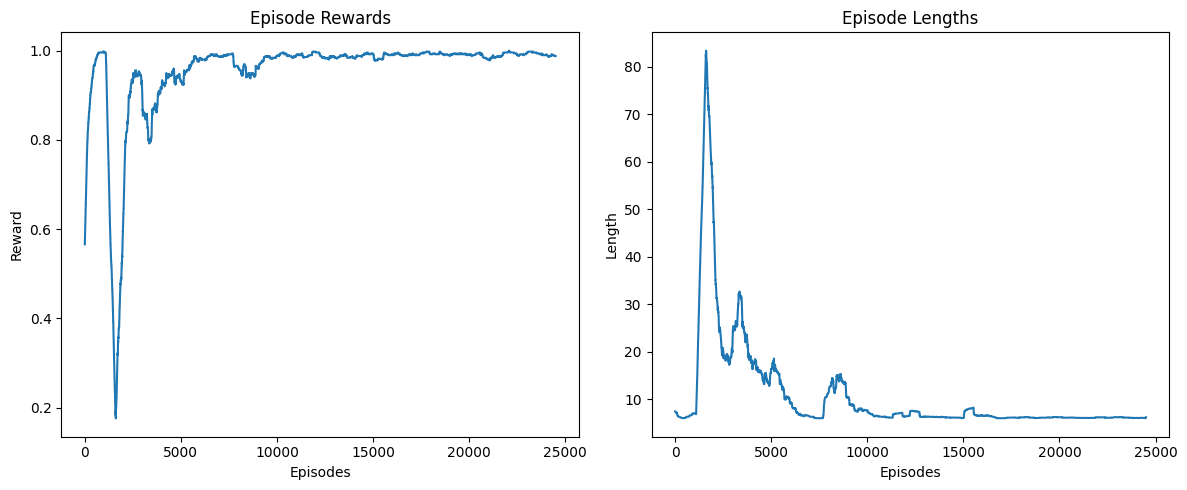

In [23]:
plot_all(episode_rewards_DQL, episode_lengths_DQL, training_errors_DQL, rolling_length=500)

Analizando las gr√°ficas obtenidas durante el entrenamiento del agente con DQN en el entorno FrozenLake 4x4, podemos destacar los siguientes puntos:

- **Evoluci√≥n de las recompensas** (Gr√°fica izquierda)
Al comienzo del entrenamiento, la recompensa media es baja y presenta fluctuaciones considerables, reflejando la fase de exploraci√≥n inicial del agente.
A medida que avanzan los episodios (antes de llegar a los 2,000 aproximadamente), la recompensa aumenta de manera notable hasta estabilizarse cerca de valores pr√≥ximos a 1. Esto indica que el agente ha aprendido a maximizar su probabilidad de alcanzar la meta.
En la etapa final, la recompensa se mantiene estable en valores altos, lo cual sugiere que el agente ha convergido a una pol√≠tica casi √≥ptima, pese a la naturaleza estoc√°stica del entorno.

- **Evoluci√≥n de la longitud de los episodios** (Gr√°fica derecha)
Durante los primeros episodios, se observan picos de duraci√≥n muy elevados (llegando a superar 80 pasos), se√±al de que el agente todav√≠a no cuenta con una estrategia clara y est√° probando m√∫ltiples rutas sin √©xito.
Con el progreso del entrenamiento, la longitud de los episodios desciende dr√°sticamente, llegando a estabilizarse en valores bajos (cercanos a 5‚Äì10 pasos), lo que indica que el agente ha encontrado rutas eficientes para resolver el entorno.
Hacia la fase final, la longitud se mantiene relativamente constante, reforzando la idea de que el agente aplica una pol√≠tica s√≥lida para llegar a la meta con el menor n√∫mero de movimientos posibles.

**Conclusi√≥n general**
El entrenamiento con Deep Q-Learning en FrozenLake 4x4 demuestra ser exitoso. El agente pasa de episodios largos con recompensas bajas a episodios m√°s cortos y recompensas cercanas al m√°ximo. La estabilidad observada en ambos gr√°ficos hacia el final del entrenamiento indica que el agente ha aprendido una pol√≠tica efectiva y robusta para navegar en un entorno estoc√°stico, maximizando su recompensa y reduciendo los movimientos innecesarios.

### 3.6 Sarsa SemiGradiente

SARSA semigradiente es una extensi√≥n del algoritmo SARSA tradicional, dise√±ada para manejar entornos con espacios de estado continuos o de alta dimensi√≥n. En estos casos, la representaci√≥n tabular de $ Q(s, a) $ se vuelve inviable, por lo que se emplean funciones de aproximaci√≥n en lugar de almacenar valores discretos para cada par estado-acci√≥n.

El m√©todo SARSA semigradiente utiliza una funci√≥n de aproximaci√≥n de la forma:

$$
Q(s, a; \theta) \approx f(s, a; \theta)
$$

donde $ \theta $ representa un conjunto de par√°metros ajustables que determinan la estimaci√≥n de los valores $ Q(s, a) $. En lugar de actualizar una tabla de valores $ Q $, se actualizan los par√°metros $ \theta $ mediante descenso de gradiente.

La actualizaci√≥n de los par√°metros $ \theta $ sigue la regla de aprendizaje:

$$
\theta \leftarrow \theta + \alpha \delta \nabla_{\theta} Q(s, a; \theta)
$$

donde:

- $\alpha $ es la tasa de aprendizaje.
- $ \delta $ es el error temporal definido como:

$$
\delta = R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}; \theta) - Q(s, a; \theta)
$$

- $ \nabla_{\theta} Q(s, a; \theta) $ es el gradiente de la funci√≥n de aproximaci√≥n respecto a los par√°metros $ \theta $.




#### Mapa 4x4

Comenzamos el c√≥digo estableciendo la semilla para los generadores de n√∫meros aleatorios en varias bibliotecas, asegurando que los experimentos sean reproducibles.
- **`seed = 1995`**: Se define el valor de la semilla como `1995`. 
- **`random.seed(seed)`**: Establece la semilla en el m√≥dulo `random` de Python.
-
- **`np.random.seed(seed)`**: Establece la semilla en el generador de n√∫meros aleatorios de NumPy. 
-
- **`torch.manual_seed(seed)`**: Establece la semilla para el generador de n√∫meros aleatorios de PyTorch en la CPU.
-
- **`if torch.cuda.is_available(): torch.cuda.manual_seed(seed)`**: Si se dispone de una GPU (es decir, si CUDA est√° disponible), esta l√≠nea establece la semilla para el generador de n√∫meros aleatorios de PyTorch en la GPU. 

In [28]:
seed = 1995
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

En este fragmento de c√≥digo, se est√° creando un entorno utilizando la clase `FrozenLakeWrapper`. con el parametro ``is_slippery = False``, para crear un entorno que no sea resbaladizo.


In [29]:
# Usamos FrozenLakeWrapper para crear el entorno
env_wrapper = FrozenLakeWrapper(is_slippery=False, map_name="4x4")


Se entrena el modelo

In [26]:
# Entrenar usando SARSA semigradiente (en vez de DQN)
episode_rewards_SSG, episode_lengths_SSG, training_errors_SSG, agent = train_sarsa(env_wrapper, num_episodes=25000, seed=seed)

c:\Users\pacol\Documents\Masters\MasterIA\2-cuatrimestre\Extensiones_de_Machine_Learning\entregas\RL_FJLGM\src_agents\sarsaSemiGradiente.py:301: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 50, Average Reward: 0.02, Epsilon: 0.78
Episode 100, Average Reward: 0.02, Epsilon: 0.61
Episode 150, Average Reward: 0.00, Epsilon: 0.47
Episode 200, Average Reward: 0.00, Epsilon: 0.37
Episode 250, Average Reward: 0.00, Epsilon: 0.29
Episode 300, Average Reward: 0.00, Epsilon: 0.22
Episode 350, Average Reward: 0.00, Epsilon: 0.17
Episode 400, Average Reward: 0.00, Epsilon: 0.13
Episode 450, Average Reward: 0.00, Epsilon: 0.10
Episode 500, Average Reward: 0.00, Epsilon: 0.10
Episode 550, Average Reward: 0.00, Epsilon: 0.10
Episode 600, Average Reward: 0.00, Epsilon: 0.10
Episode 650, Average Reward: 0.00, Epsilon: 0.10
Episode 700, Average Reward: 0.00, Epsilon: 0.10
Episode 750, Average Reward: 0.00, Epsilon: 0.10
Episode 800, Average Reward: 0.08, Epsilon: 0.10
Episode 850, Average Reward: 0.78, Epsilon: 0.10
Episode 900, Average Reward: 0.86, Epsilon: 0.10
Episode 950, Average Reward: 0.82, Epsilon: 0.10
Episode 1000, Average Reward: 0.82, Epsilon: 0.10
Episode 1050, Averag

**Conclusi√≥n**

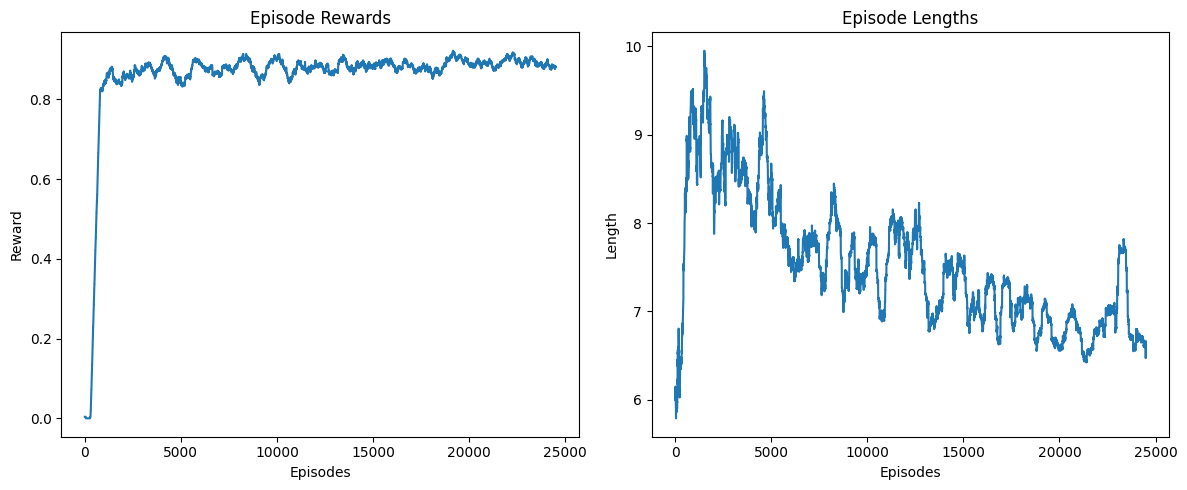

In [27]:
plot_all(episode_rewards_SSG, episode_lengths_SSG, training_errors_SSG, rolling_length=500)

Analizando las gr√°ficas obtenidas durante el entrenamiento del agente con **Sarsa semigradiente** en el entorno **FrozenLake**, podemos destacar los siguientes puntos:


**Evoluci√≥n de las recompensas** (Gr√°fica izquierda)
    - Al inicio del entrenamiento, las recompensas son bajas y muestran una alta variabilidad, lo cual indica que el agente se encuentra en fase de exploraci√≥n y a√∫n no ha desarrollado una estrategia clara.  
    - A medida que avanza el entrenamiento (alrededor de los primeros miles de episodios), la recompensa media asciende r√°pidamente, situ√°ndose cerca de valores de 0.8‚Äì0.9. Esto sugiere que el agente aprende a tomar decisiones que le permiten alcanzar la meta con mayor frecuencia.  
    - En la fase final, la recompensa se mantiene relativamente estable cerca de valores altos, lo que indica que el agente ha convergido a una pol√≠tica casi √≥ptima.


**Evoluci√≥n de la longitud de los episodios** (Gr√°fica derecha)
    - Durante los primeros episodios, la longitud de los mismos es relativamente alta y presenta fluctuaciones considerables, reflejando la exploraci√≥n intensa del agente y la ausencia de una ruta clara hacia la meta.  
    - Conforme el agente adquiere experiencia, se observa una tendencia a la baja en la duraci√≥n de los episodios. Esto indica que el agente aprende a llegar a la meta en menos pasos o, en caso de fallar, lo hace antes, reduciendo el tiempo total del episodio.  
    - En la etapa final del entrenamiento, la longitud de los episodios se estabiliza en valores m√°s bajos, lo que demuestra que el agente ha aprendido la ruta m√°s eficiente para resolver el entorno con el m√≠nimo n√∫mero de movimientos posibles.

**Conclusi√≥n general**
    El entrenamiento con **Sarsa semigradiente** en **FrozenLake** muestra resultados exitosos. El agente pasa de una fase de exploraci√≥n err√°tica, con bajas recompensas y episodios largos, a una estrategia consistente que maximiza la recompensa y minimiza la duraci√≥n de los episodios. Aunque el entorno estoc√°stico impide alcanzar un √©xito absoluto, el rendimiento final del agente es alto y refleja la convergencia hacia una pol√≠tica efectiva y estable.

## **4. Conclusi√≥n**

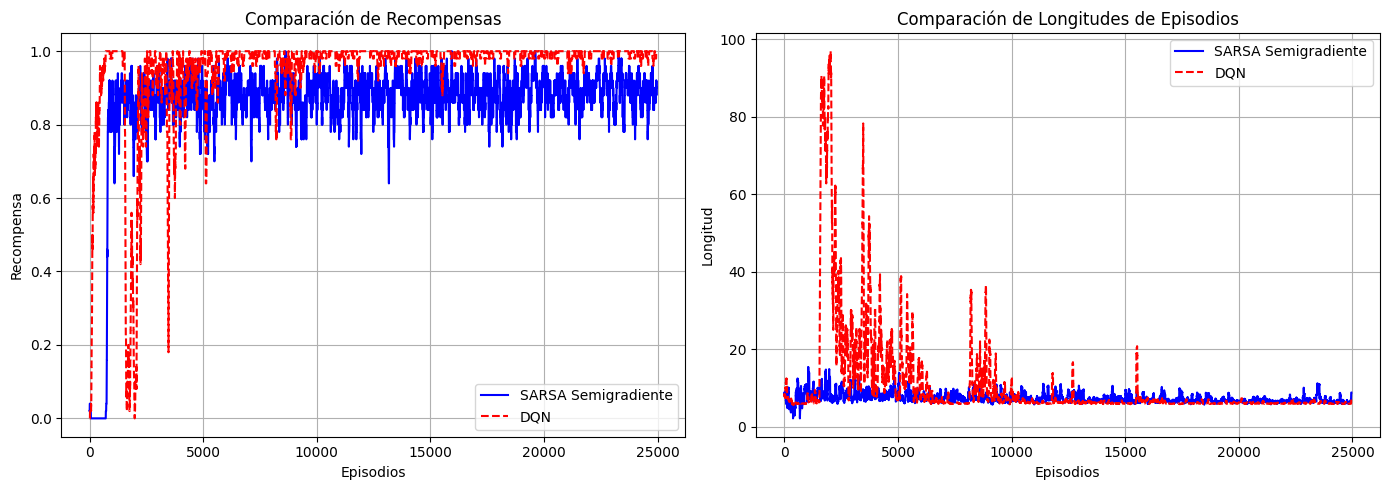

In [19]:
plot_comparative_results(episode_rewards_SSG, episode_lengths_SSG, 
                         episode_rewards_DQL, episode_lengths_DQL, 
                         label1="SARSA Semigradiente", label2="DQN",
                         rolling_length=50)

Analizando las gr√°ficas comparativas de Sarsa Semigradiente (l√≠nea azul) y DQN (l√≠nea roja punteada) en el entorno FrozenLake 4x4, se pueden destacar los siguientes puntos:

**Comparaci√≥n de Recompensas** (Gr√°fica izquierda)
- Fase inicial:
Tanto Sarsa Semigradiente como DQN comienzan con recompensas bajas e inestables, reflejando la etapa de exploraci√≥n y la falta de una estrategia definida.  

- Progreso:
Sarsa Semigradiente muestra un ascenso paulatino hasta situarse cerca de valores de recompensa cercanos a 1, manteni√©ndose relativamente estable en ese rango.
DQN experimenta un incremento m√°s r√°pido en las recompensas, pero presenta picos de inestabilidad en algunos tramos, donde la recompensa cae bruscamente antes de recuperarse.

Ambos m√©todos alcanzan recompensas promedio altas, lo que indica que aprenden pol√≠ticas eficaces para superar el entorno. Sin embargo, DQN exhibe mayor variabilidad.

**Comparaci√≥n de Longitudes de Episodios** (Gr√°fica derecha)

- Fase inicial:
Al inicio, la duraci√≥n de los episodios para DQN es muy elevada, mientras que Sarsa Semigradiente se mantiene en rangos algo m√°s moderados, aunque tambi√©n inestables.  

- Progreso:
Con el paso de los episodios, ambas estrategias reducen significativamente la longitud media de los episodios. Esto sugiere que, al aprender la din√°mica del entorno, el agente encuentra rutas m√°s eficientes para llegar a la meta o, en caso de fallar, lo hace de forma m√°s r√°pida.

Sarsa Semigradiente logra estabilizarse en valores relativamente bajos, mostrando una curva m√°s homog√©nea.
DQN reduce tambi√©n la duraci√≥n de los episodios a valores bajos, pero sufre picos ocasionales que indican cierta inestabilidad en la pol√≠tica aprendida.

**Conclusi√≥n general**
Tanto Sarsa Semigradiente como DQN consiguen resolver de manera efectiva el entorno FrozenLake 4x4, alcanzando recompensas altas y reduciendo dr√°sticamente la longitud de los episodios. No obstante, se aprecian diferencias en la estabilidad del aprendizaje:

Basandonos √∫nicamente en la estabilidad y la consistencia de los resultados, Sarsa Semigradiente parece ser la mejor opci√≥n en este experimento con FrozenLake 4x4. Aunque DQN puede alcanzar recompensas similares o incluso aprender un poco m√°s r√°pido en ciertos tramos, presenta m√°s fluctuaciones tanto en la recompensa como en la longitud de los episodios, lo que indica una pol√≠tica menos estable.
